# ДЗ 1:

### Дизайн теста
1) Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

2) Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (0.5 балла)

3) На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (1.5 балла)

4) Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (1 балл)

### A/B тест
1) Представим что у нас прошел тест, используем те же самые данные за 2 недели

2) Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (0.5 балла)

3) Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (0.5 балла)

4) Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (1 балл)

5) Посчитайте результат такого теста и сделайте выводы (2 балла)

Еще 1 балл можно получить за хорошее и подробное объяснение каждого шага 

In [2]:
import requests
from tqdm import tqdm

# download dataset by chunks
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download: 100%|██████████| 78.8M/78.8M [01:13<00:00, 1.12MiB/s]

kion dataset download: 100%|██████████| 78.8M/78.8M [01:30<00:00, 1.12MiB/s]

In [3]:
# Распаковываем архив из 3 файлов
import zipfile

with zipfile.ZipFile('data_kion.zip', 'r') as zip_ref:
    zip_ref.extractall()

### Дизайн теста

##### 1. Получение данных

In [14]:
import pandas as pd
import numpy as np


interactions = pd.read_csv('data_kion/interactions_df.csv')
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [15]:
max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()
print(min_date, max_date)

2021-03-13 2021-08-22


In [17]:
import datetime

max_date = interactions['last_watch_dt'].max()
two_weeks = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=13)]
min_date = two_weeks['last_watch_dt'].min()

min_date, max_date

(datetime.date(2021, 8, 9), datetime.date(2021, 8, 22))

In [28]:
two_weeks = two_weeks.groupby('user_id', as_index=False).agg({'total_dur': sum})
two_weeks.head()

C:\Users\hello\AppData\Local\Temp\ipykernel_17540\4014611418.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  two_weeks = two_weeks.groupby('user_id', as_index=False).agg({'total_dur': sum})


,user_id,total_dur
0,1,21172
1,1000,10744
2,1000000,32990
3,1000001,52
4,1000003,625


<Axes: >

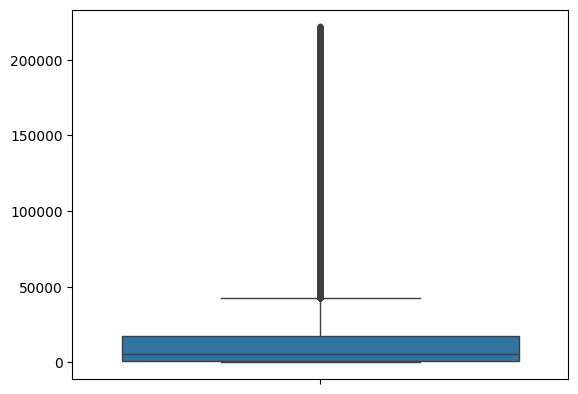

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(two_weeks['total_dur'].values, fliersize=3)

In [32]:
print(two_weeks.shape)
two_weeks = two_weeks[(two_weeks['total_dur'] < two_weeks['total_dur'].std() * 3)]
print(two_weeks.shape)

(266081, 2)
(262794, 2)


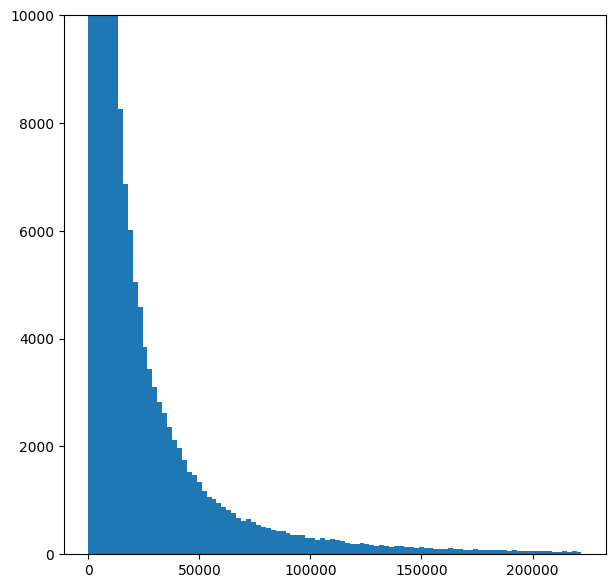

In [33]:
two_weeks['total_dur'].hist(bins=100, figsize=(7,7))
plt.ylim([0, 10000])
plt.grid(False)

##### 2. Корректность на Бутстрепе

Доля пар в которых была найдена стат. значимость (хотя ее не должно быть) - это ошибка первого рода, та самая альфа

In [34]:
import os
from base64 import b64encode
import hashlib
import collections


def groups_splitter(df, columns, user_salt=None):
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())
    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()

def salt_generator(salt=None):
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')


def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))


def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result

In [39]:
def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

In [49]:
correctness = []
values = []

for _ in tqdm(range(1000)):
    new_df = groups_splitter(two_weeks.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

    # bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                          [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    correctness.append(not left_side <= 0 <= right_side)

test_correctness = collections.Counter(correctness)

print(f'Significance: {test_correctness[1] / (test_correctness[1] + test_correctness[0]) * 100}%')

100%|██████████| 1000/1000 [2:03:00<00:00,  7.38s/it]

Significance: 4.1000000000000005%


ВЫВОД: корректность 4.1%, близка к типичному уровню альфа = 0.05, посчитанному на семинаре

Соответственно наша альфа (ошибка первого рода) при подсчете MDE будет равна __0.041__

In [ ]:
p_values = [get_p_value(dist) for dist in values]

plt.hist(p_values, bins=10, color='purple')
plt.title(f"Бутстреп распределение p_value")
plt.show()

Давайте еще проверим критерием Колмогорова-Смирнова (о том, что получившееся распределение p_values есть равномерное распределение)

In [51]:
import scipy

stat, p_value = scipy.stats.kstest(p_values, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.6566398438826642 - p_values равномерное распределение


##### 3. Мощность на Бутстрепе

С добавленным эффектом на второй группе - Доля пар в которых НЕ была найдена стат. значимость (хотя должна быть) - это ошибка второго рода, та самая бета

In [53]:
power_1_percent = []
power_3_percent = []
power_5_percent = []

values_1_percent = []
values_3_percent = []
values_5_percent = []

for _ in tqdm(range(1000)):
    new_df = groups_splitter(two_weeks.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

    # докидываем эффект 1%, 3% и 5% соответственно
    vec_b_1_percent = vec_b * 1.01
    vec_b_3_percent = vec_b * 1.03
    vec_b_5_percent = vec_b * 1.05

    # bootstrap, считаем среднии для групп
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
    sample_b_1_percent_mean = calc_bootstrap_mean(vec_b_1_percent, size=1000)
    sample_b_3_percent_mean = calc_bootstrap_mean(vec_b_3_percent, size=1000)
    sample_b_5_percent_mean = calc_bootstrap_mean(vec_b_5_percent, size=1000)

    # добавляем разницы средних
    values_1_percent.append(sample_a_mean - sample_b_1_percent_mean)
    values_3_percent.append(sample_a_mean - sample_b_3_percent_mean)
    values_5_percent.append(sample_a_mean - sample_b_5_percent_mean)

    # доверительный интервал для 1%
    left_side, right_side = np.percentile(sample_a_mean - sample_b_1_percent_mean,
                                          [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])
    power_1_percent.append(not left_side <= 0 <= right_side)

    # доверительный интервал для 3%
    left_side, right_side = np.percentile(sample_a_mean - sample_b_3_percent_mean,
                                          [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])
    power_3_percent.append(not left_side <= 0 <= right_side)

    # доверительный интервал для 5%
    left_side, right_side = np.percentile(sample_a_mean - sample_b_5_percent_mean,
                                          [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])
    power_5_percent.append(not left_side <= 0 <= right_side)

test_power_1_percent = collections.Counter(power_1_percent)
test_power_3_percent = collections.Counter(power_3_percent)
test_power_5_percent = collections.Counter(power_5_percent)

print(f'Power for 1%: {test_power_1_percent[1] / (test_power_1_percent[1] + test_power_1_percent[0]) * 100}%')
print(f'Power for 3%: {test_power_3_percent[1] / (test_power_3_percent[1] + test_power_3_percent[0]) * 100}%')
print(f'Power for 5%: {test_power_5_percent[1] / (test_power_5_percent[1] + test_power_5_percent[0]) * 100}%')

100%|██████████| 1000/1000 [3:45:15<00:00, 13.52s/it]

Power for 1%: 31.8%
Power for 3%: 99.5%
Power for 5%: 100.0%


ВЫВОД: посмотрим на бутстрек с эффектом в 1%, бета (ошибка второго рода) = __0.32__, а мощность, которая вычисляется как 1 - бета, = 0.68

Логичным будет взять эту бету, так как чем выше мощность тем более низкий эффект мы можем стат. значимо зафиксировать. А именно эта бета дает нам максимальную мощность

##### Подсчет MDE

In [ ]:
from scipy.stats import norm

def get_mde(metric_vec, alpha=0.05, beta=0.2):
    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()

    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)

    mde = (z_alpha + z_beta) * metric_std / np.sqrt(metric_n)

    return mde * 100 / metric_mean

In [ ]:
alpha = 0.041
beta = 0.32

mde = get_mde()